# Book Recommender System With Keras 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns #for visualisation

In [ ]:
import pandas as pd
dataset = pd.read_csv("drive/My Drive/datasets/ratings_Beauty.csv", encoding='latin1')
# dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Beauty.csv')

In [ ]:
# dataset = pd.read_csv('https://raw.githubusercontent.com/sahilpocker/Book-Recommender-System/master/Dataset/ratings.csv')
 
dataset.drop_duplicates(inplace=True) #Drop duplicate entries
 
print('we have',dataset.shape[0], 'ratings')
dataset.head()

we have 2023070 ratings


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


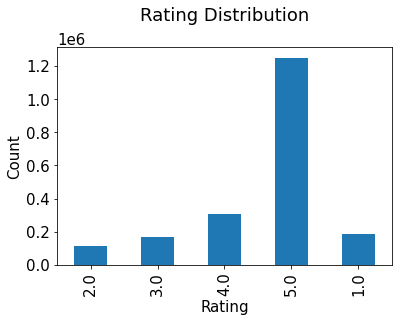

In [ ]:
plt.rc("font", size=15)
dataset.Rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

**Visualising the number of ratings per book: -**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


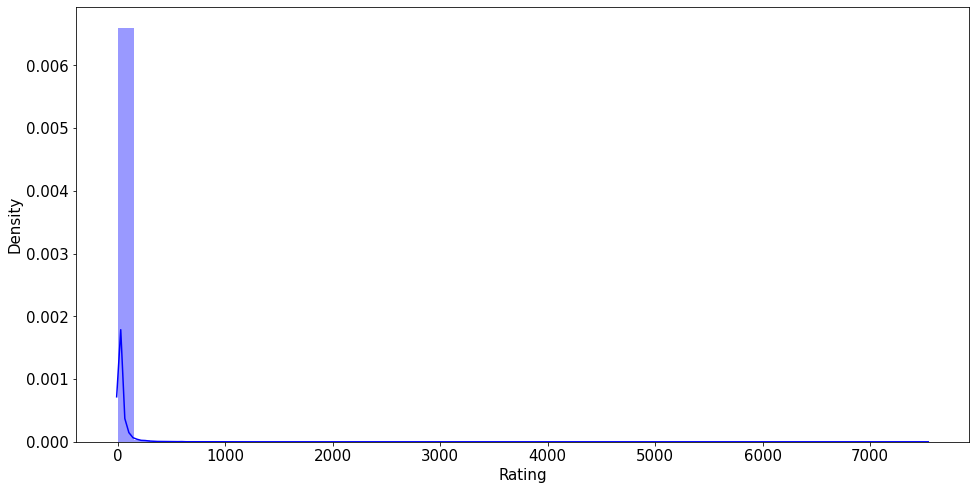

In [ ]:
no_of_ratings_per_book=dataset.groupby('ProductId').count()
plt.figure(figsize=(16,8))
sns.distplot(a=no_of_ratings_per_book['Rating'], color='b')

In [ ]:
dataset= dataset.head(1000)




**The user_id and product_id in the dataset is currently non-sequential, it is required to convert them into sequential (starting from zero). Scikit-learn’s LabelEncoder class helps to transform the fields.**

In [ ]:
#user
user_enc = LabelEncoder()
dataset['user'] = user_enc.fit_transform(dataset['UserId'].values)
n_users = dataset['user'].nunique()

#product
item_enc = LabelEncoder()
dataset['products'] = item_enc.fit_transform(dataset['ProductId'].values)
n_products = dataset['products'].nunique()

dataset['Rating'] = dataset['Rating'].values.astype(np.float32) 

min_rating = min(dataset['Rating'])
max_rating = max(dataset['Rating'])

print('the number of unique users we have is:', n_users)
print('the number of unique books we have is:', n_products)
print("The median user rated %d books."%dataset.UserId.value_counts().median())
print('The max rating is: %d'%min_rating,"the min rating is: %d"%max_rating)
dataset.tail()

the number of unique users we have is: 948
the number of unique books we have is: 261
The median user rated 1 books.
The max rating is: 1 the min rating is: 5


,UserId,ProductId,Rating,Timestamp,user,products
995,A3317L1113QN7O,978807894X,5.0,1387843200,529,260
996,A3ABTLXPQP73TB,978807894X,3.0,1273276800,580,260
997,A2P2FTA24RAFBA,978807894X,5.0,1395014400,438,260
998,A2CB2CNAOCG97W,978807894X,5.0,1395014400,346,260
999,A29WP9HRKLQS0D,978807894X,5.0,1295740800,332,260


**Split into training and test sets, with an 80-20 split.**

In [ ]:
# Spliting the data into train and test
X = dataset[['user', 'products']].values
y = dataset['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [ ]:
# Created arrays from our x_train values to be passed into the model
n_factors = 20 #No of factors per user/book (A hyperparameter)
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

**Define the model.**

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2


def RecommenderNet(n_users, n_products, n_factors):
    user = Input(shape=(1,)) 
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    prods = Input(shape=(1,))
    m = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(prods)
    m = Reshape((n_factors,))(m)

    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, prods], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderNet(n_users, n_products, n_factors)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        18960       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        18960       input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
13/13 [==============================] - 4s 46ms/step - loss: 19.2628 - val_loss: 18.0257
Epoch 2/5
13/13 [==============================] - 0s 6ms/step - loss: 18.7408 - val_loss: 18.0252
Epoch 3/5
13/13 [==============================] - 0s 5ms/step - loss: 18.8927 - val_loss: 18.0249
Epoch 4/5
13/13 [==============================] - 0s 6ms/step - loss: 18.8489 - val_loss: 18.0249
Epoch 5/5
13/13 [==============================] - 0s 6ms/step - loss: 18.9246 - val_loss: 18.0248


**Taking a look at the model perfomance, it has performed decently well. More epochs would only cause the model to overfit.**

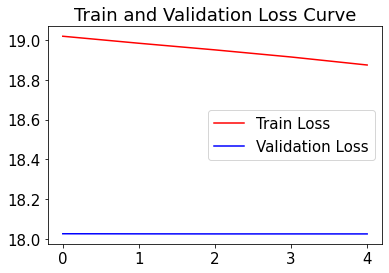

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pickle 

In [ ]:
model.save('my_model.h5')

# Making Recommendations

In [ ]:
dataset.to_csv('product.csv')

**We can use the model to predict the top 10 recommendations for a user**

In [ ]:
dataset.head()

,UserId,ProductId,Rating,Timestamp,user,products
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,570,0
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,647,1
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,250,1
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,235,2
4,A3IAAVS479H7M7,0737104473,1.0,1274227200,643,3


In [ ]:
#Making recommendations for user
def recommend(user_ID):
  user_r =user_ID
  prod_id =list(dataset.products.unique())
  prod_arr = np.array(prod_id)
  user = np.array([user_r for i in range(len(prod_id))])
  pred = model.predict([prod_arr, user])
  # pred

  pred = pred.reshape(-1) #reshape to single dimension
  pred_ids = (-pred).argsort()[0:10]
  
  # pred_ids
  top10 = dataset.iloc[pred_ids]
  f=['ProductId']
  displ=(top10[f])
  print(displ)

In [ ]:
recommend(500)

      ProductId
213  5357955867
209  5357955786
37   1304351475
5    0762451459
177  4057368825
18   1304174867
95   130465110X
41   1304351475
94   1304651088
58   1304511081


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-04-10 22:13:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.202.136.204, 34.207.48.100, 3.216.86.20, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.202.136.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14746350 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.06M  59.5MB/s    in 0.2s    

2021-04-10 22:13:04 (59.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14746350/14746350]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
!pip install -q pyngrok
!pip install -q streamlit
!pip install -q streamlit_ace

     |████████████████████████████████| 747kB 23.5MB/s 
     |████████████████████████████████| 8.2MB 12.2MB/s 
     |████████████████████████████████| 112kB 61.9MB/s 
     |████████████████████████████████| 4.6MB 48.3MB/s 
     |████████████████████████████████| 163kB 61.2MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 122kB 59.4MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.3 which is incompatible.
     |████████████████████████████████| 3.9MB 19.7MB/s 


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: http://b654c0050482.ngrok.io


In [ ]:
%%writefile app.py 
import pickle
import streamlit as st
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.load_model('my_model.h5')
# front end elements of the web page 
html_temp = """ 
<div style ="background-color:yellow;padding:13px"> 
<h1 style ="color:black;text-align:center;">Streamlit Loan Prediction ML App</h1> 
</div> 
""" 
st.markdown(html_temp, unsafe_allow_html = True) 
default_value_goes_here = ""
user_r = st.text_input("label goes here", default_value_goes_here)
dataset= pd.read_csv('https://raw.githubusercontent.com/Diane10/movies/main/product.csv')
if st.button("Predict"): 
  b_id =list(dataset.book.unique())
  book_arr = np.array(b_id)
  user_r=int(user_r)
  user = np.array([user_r for i in range(len(b_id))])
  pred = model.predict([book_arr, user])
  pred = pred.reshape(-1)
  pred_ids = (-pred).argsort()[0:10]
  top10 = dataset.iloc[pred_ids]
  f=['ProductId']
  displ=(top10[f])
  st.write(displ)

Writing app.py


In [ ]:
!streamlit run app.py &>/dev/null&

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect('8501')
public_url

t=2021-04-10T22:14:23+0000 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040


<NgrokTunnel: "http://d289346df062.ngrok.io" -> "http://localhost:8501">

Part2

In [ ]:
import pandas as pd
product_descriptions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_descriptions.csv')
product_descriptions.head()

In [ ]:
# Importing libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

In [ ]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]

product_descriptions1["product_description"].head(10)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])
X1

In [ ]:
# Fitting K-Means to the dataset
X=X1
kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [ ]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [ ]:
true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

In [ ]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [ ]:
show_recommendations("cutting tool")

In [ ]:
show_recommendations("water")